## Imports

In [ ]:
import optuna.visualization as viz
from plotly.io import show
from utils.config import CFG
import joblib
from hyperopt import *

from models.ProtTransClassifier import ProtTransClassifier
from utils.cross_validation import kfoldCV
from utils.training_utils import init_trainer, init_loaders
from utils.dataset_utils import load_csv
from utils.plotting import plot_history
from ProteinDataset import ProtTransDataset
from Trainer import EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
import torch
from sklearn.metrics import balanced_accuracy_score

import plotly.io as pio
pio.renderers.default = "png"

# Model optimization for 5 classes

We perform both Neural Architecture Search and hyperparameter optimization using bayesian optimization.

In [2]:
assert CFG.num_classes == 5

In [3]:
model_config = CFG['ProtTransMLP']
model = ProtTransClassifier(model_config)

In [ ]:
study = optimize_hyperparameters(
    model, 
    model_config,
    obj_builder=objective_MLP,
    n_trials=CFG['hyperopt']['num_trials']
)

In [5]:
path = CFG.root_dir / CFG["paths"]["save_dir"] / "optuna"
study = joblib.load(path / 'ProtTransClassifier_5classes_study.pkl')
apply_best_config(study, model_config)

print("Best hyperparameters found: ")
for param in study.best_params:
    print(f"{param}: {study.best_params[param]}")

Best hyperparameters found: 
n_hidden: 3
hidden_dim_0: 128
hidden_dim_1: 2048
hidden_dim_2: 2048
batch_norm: False
dropout_rate: 0.44958737567521356
learning_rate: 0.001224344113829869
weight_decay: 4.046019179411917e-05


## Perform cross-validation on optimized model

In [ ]:
df = load_csv(CFG.train_data)
dataset = ProtTransDataset(df, CFG.train_data)

model = ProtTransClassifier(CFG['ProtTransMLP'])
trainer = init_trainer(model, CFG['ProtTransMLP'])

ES = EarlyStopping(patience=12)

CV_loss = kfoldCV(trainer, dataset, 5, CFG['ProtTransMLP']['training']['epochs'])

In [7]:
print(f"k_fold CV loss: {CV_loss}")

k_fold CV loss: 0.01129537073413443


## Visualize hyperopt statistics

#### Hyperparameter importance

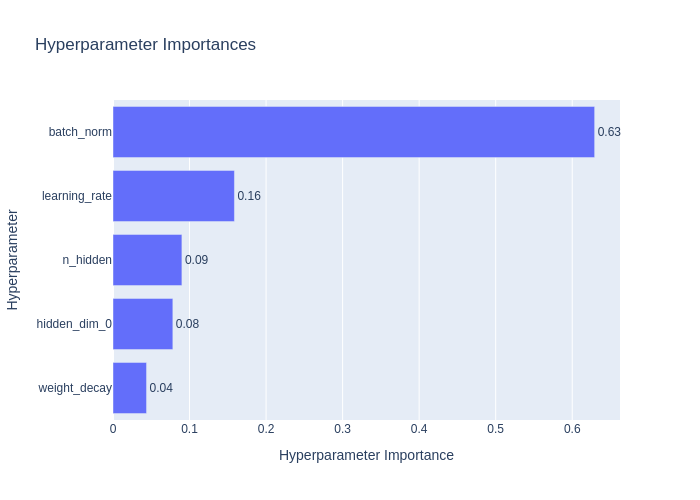

In [8]:
path = CFG.root_dir / CFG["paths"]["save_dir"] / "optuna"
study_name = "ProtTransClassifier_5classes_study.pkl"
study = joblib.load(path / study_name)
fig = viz.plot_param_importances(study)
show(fig)

#### 2D contour plot of hyperparameter correlation and influence on model loss

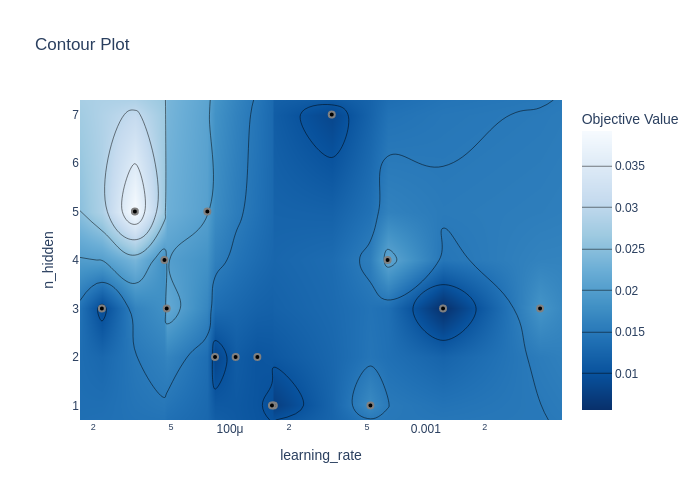

In [9]:
fig = viz.plot_contour(study, params=["n_hidden", "learning_rate"])
show(fig)

#### Optimization timeline

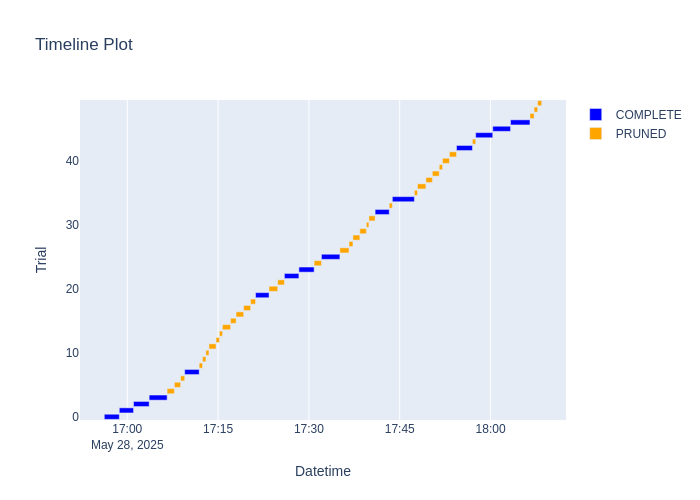

In [10]:
fig = viz.plot_timeline(study)
show(fig)

## Final Model Training

In [25]:
model_cfg = CFG["ProtTransMLP"]

train_loader, val_loader = init_loaders(model_cfg)
model = ProtTransClassifier(model_cfg)
trainer = init_trainer(model, model_cfg)
ES = EarlyStopping(patience=7)

trainer.train(train_loader, val_loader, epochs=30, early_stopping=ES)


Epoch 1/30:   0%|          | 0/668 [00:00<?, ?it/s]

[1/30] Train Loss: 0.0433


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9977
	f1_score: 0.9977
[1/30] Val Loss: 0.0078 



Epoch 2/30:   0%|          | 0/668 [00:00<?, ?it/s]

[2/30] Train Loss: 0.0104


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9970
	f1_score: 0.9970
[2/30] Val Loss: 0.0135 



Epoch 3/30:   0%|          | 0/668 [00:00<?, ?it/s]

[3/30] Train Loss: 0.0101


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9986
	f1_score: 0.9986
[3/30] Val Loss: 0.0057 



Epoch 4/30:   0%|          | 0/668 [00:00<?, ?it/s]

[4/30] Train Loss: 0.0092


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9987
	f1_score: 0.9987
[4/30] Val Loss: 0.0055 



Epoch 5/30:   0%|          | 0/668 [00:00<?, ?it/s]

[5/30] Train Loss: 0.0093


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9965
	f1_score: 0.9966
[5/30] Val Loss: 0.0177 



Epoch 6/30:   0%|          | 0/668 [00:00<?, ?it/s]

[6/30] Train Loss: 0.0082


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9984
	f1_score: 0.9984
[6/30] Val Loss: 0.0070 



Epoch 7/30:   0%|          | 0/668 [00:00<?, ?it/s]

[7/30] Train Loss: 0.0075


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9974
	f1_score: 0.9974
[7/30] Val Loss: 0.0166 



Epoch 8/30:   0%|          | 0/668 [00:00<?, ?it/s]

[8/30] Train Loss: 0.0087


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9967
	f1_score: 0.9967
[8/30] Val Loss: 0.0217 



Epoch 9/30:   0%|          | 0/668 [00:00<?, ?it/s]

[9/30] Train Loss: 0.0081


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9977
	f1_score: 0.9977
[9/30] Val Loss: 0.0140 



Epoch 10/30:   0%|          | 0/668 [00:00<?, ?it/s]

[10/30] Train Loss: 0.0073


Evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

	accuracy: 0.9985
	f1_score: 0.9985
[10/30] Val Loss: 0.0147 
Stopping training due to EarlyStopping


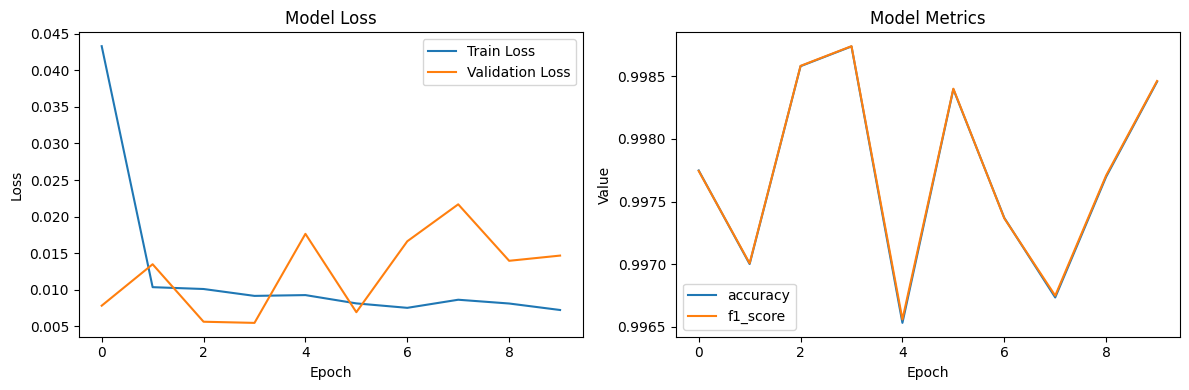

In [26]:
plot_history(trainer.history)

In [27]:
trainer.save_model(CFG.root_dir / 'outputs/trained_models')
trainer.save_history(CFG.root_dir / 'outputs/training_history')

Model ProtTransClassifier_5class.pt saved to /home/matteo/Desktop/DeepLife/protein-function-prediction/outputs/trained_models
History ProtTransClassifier_5class_history.pt saved to /home/matteo/Desktop/DeepLife/protein-function-prediction/outputs/training_history


# Model evaluation

In [31]:
df_test = load_csv(CFG.test_data)
test_data = ProtTransDataset(df_test, CFG.test_data)
test_loader = DataLoader(test_data, batch_size=256, num_workers=8)

y_pred, y_true, _ = trainer.predict(test_loader) 
print(f"Test accuracy: {balanced_accuracy_score(y_true, y_pred, adjusted=True)}")

Evaluation:   0%|          | 0/139 [00:00<?, ?it/s]

Test accuracy: 0.997763138677068


Save predictions to csv

In [32]:
def int_to_onehot(y, num_classes=CFG.num_classes):
    mat = torch.zeros((len(y), num_classes+1))
    for i, idx in enumerate(y):
        mat[i, idx] = 1
    return mat

In [33]:
y_pred_onehot = int_to_onehot(y_pred, CFG.num_classes)

encoder = test_data.label_encoder
y_pred_names = encoder.inverse_transform(y_pred_onehot)

df_pred = pd.Series(y_pred_names, name='prediction')

df_pred = pd.concat([df_test['sequence'], df_pred], axis=1)
df_pred.to_csv(CFG.root_dir / 'outputs/predictions/ProtTransClassifier_5classes_predictions.csv', index=False)